In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from collections import defaultdict
import os

file_counts = defaultdict(int)

for dirname, _, filenames in os.walk('/kaggle/input/mri-scan-images'):
    file_counts[dirname] += len(filenames)

# Display total files per subdirectory
for dir_name, count in file_counts.items():
    print(f"{dir_name}: {count} files")

/kaggle/input/mri-scan-images: 0 files
/kaggle/input/mri-scan-images/Training: 0 files
/kaggle/input/mri-scan-images/Training/pituitary: 1457 files
/kaggle/input/mri-scan-images/Training/notumor: 1595 files
/kaggle/input/mri-scan-images/Training/meningioma: 1339 files
/kaggle/input/mri-scan-images/Training/glioma: 1321 files
/kaggle/input/mri-scan-images/Testing: 0 files
/kaggle/input/mri-scan-images/Testing/pituitary: 300 files
/kaggle/input/mri-scan-images/Testing/notumor: 405 files
/kaggle/input/mri-scan-images/Testing/meningioma: 306 files
/kaggle/input/mri-scan-images/Testing/glioma: 300 files


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
dataset_path = '/kaggle/input/mri-scan-images/Training'

# Get the class names
classes = os.listdir(dataset_path)

# Print the size of each class
for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    num_images = len(os.listdir(class_path))
    print(f"Class: {cls}, Number of images: {num_images}")

Class: pituitary, Number of images: 1457
Class: notumor, Number of images: 1595
Class: meningioma, Number of images: 1339
Class: glioma, Number of images: 1321


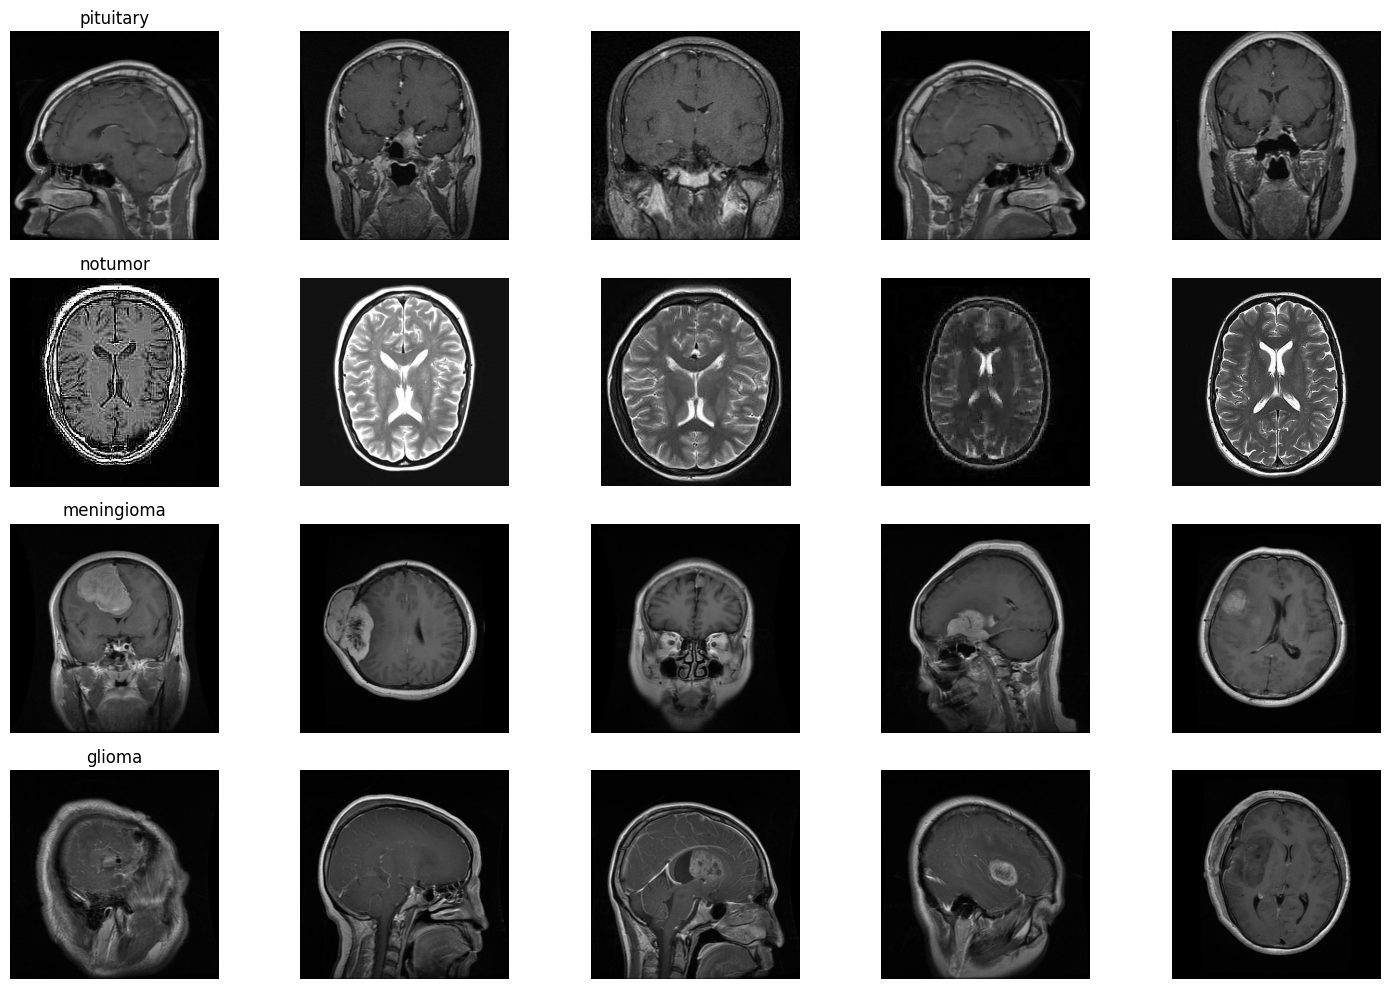

In [16]:
# Function to plot 5 images from each class
def plot_images(dataset_path, classes):
    fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(dataset_path, cls)
        images = os.listdir(class_path)[:5]  # Take the first 5 images
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls)
    
    plt.tight_layout()
    plt.show()

# Plot 5 images from each class
plot_images(dataset_path, classes)

In [18]:
# Define dataset directories
train_dir = "/kaggle/input/mri-scan-images/Training"
test_dir = "/kaggle/input/mri-scan-images/Testing"

# Get all image paths without printing them
train_image_paths = glob.glob(f"{train_dir}/*/*.jpg")
test_image_paths = glob.glob(f"{test_dir}/*/*.jpg")

In [19]:
# Image size (Xception requires 299x299)
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32

# Data Augmentation (Fine-tuned)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,      
    width_shift_range=0.3,  
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:


# Load Training Data
train_loader = train_datagen.flow_from_directory(
    train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Convert Testing Data to DataFrame for Splitting
test_loader = test_datagen.flow_from_directory(
    test_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [22]:
# Create DataFrame of Image Paths & Classes
file_paths = [os.path.join(test_dir, fname) for fname in test_loader.filenames]
test_df = pd.DataFrame({"Class Path": file_paths, "Class": test_loader.classes})
test_df["Class"] = test_df["Class"].astype(str)  # Convert to string

In [24]:
# Split Testing Data into Validation & Final Test (50% each)
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df["Class"])

# Load Validation Data
valid_gen = test_datagen.flow_from_dataframe(valid_df, x_col="Class Path",
                                             y_col="Class", batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SIZE, class_mode='categorical')

# Load Final Test Data
test_gen = test_datagen.flow_from_dataframe(test_df, x_col="Class Path",y_col="Class", batch_size=16,target_size=IMAGE_SIZE, 
                                            class_mode='categorical',
                                            shuffle=False)

# Print Class Labels
class_labels = list(train_loader.class_indices.keys())
print(f"Class Labels: {class_labels}")

Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Class Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,140,780 (80.65 MB)

 Trainable params: 21,086,252 (80.44 MB)

 Non-trainable params: 54,528 (213.00 KB)

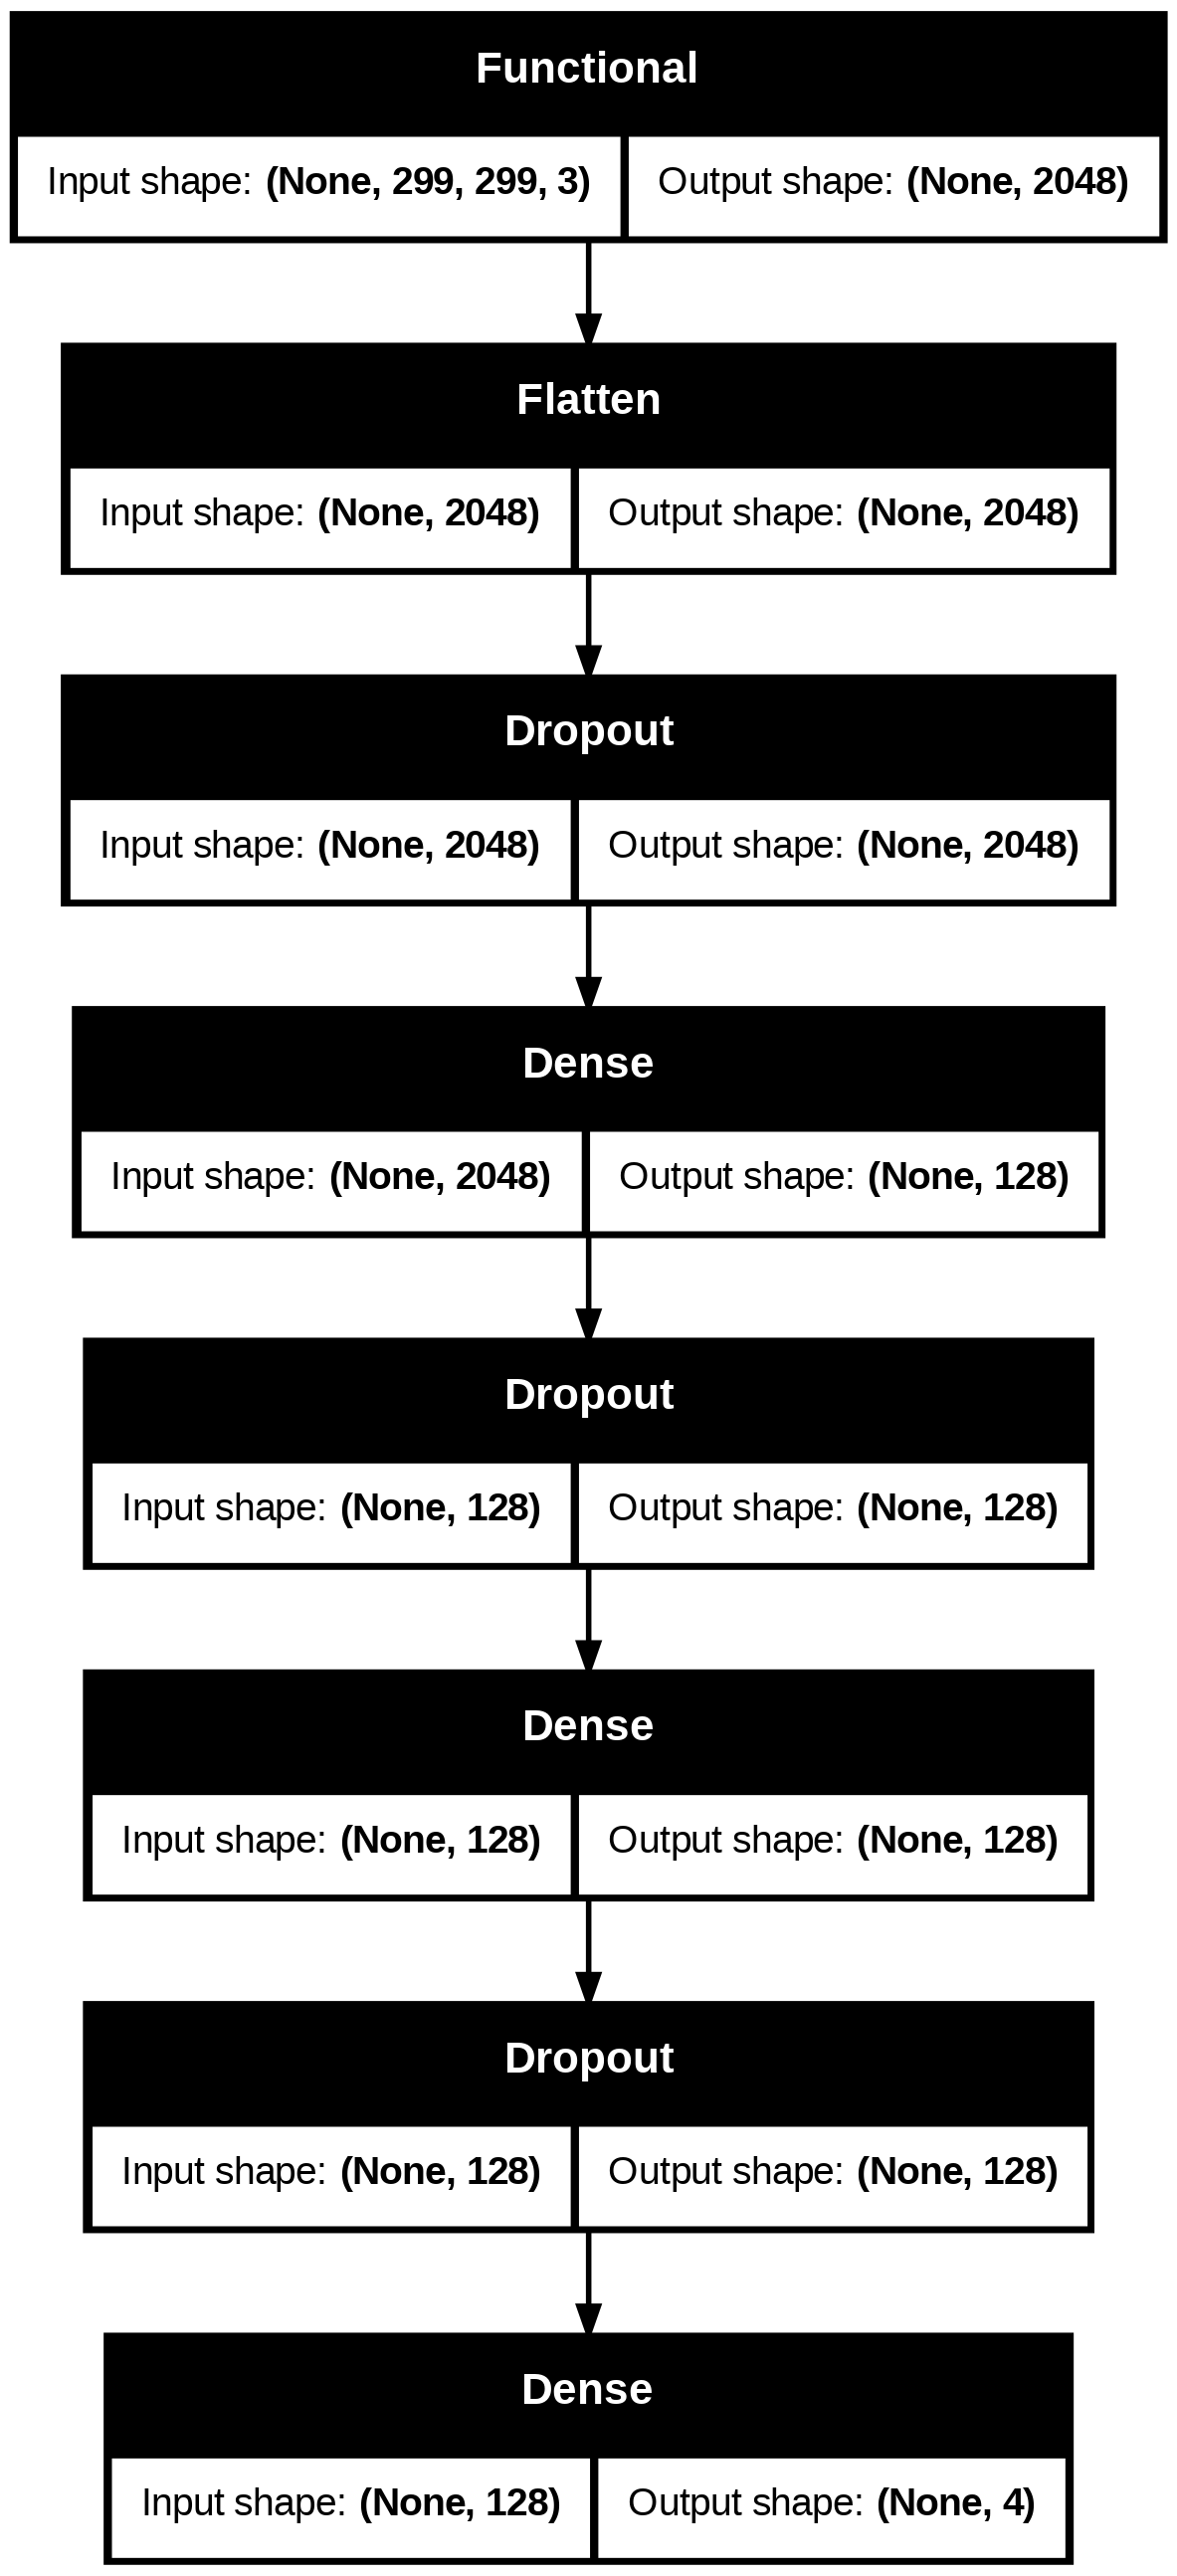

In [26]:
# Define input shape
input_shape = (299, 299, 3)

# Load Pretrained Xception Model
base_model = Xception(include_top=False, weights="imagenet",
                      input_shape=input_shape, pooling='max')


# Define Model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(128, activation= 'relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile Model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Print Model Summary
model.summary()

# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
# Early Stopping & ReduceLROnPlateau Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# Train Model with Early Stopping & ReduceLROnPlateau
hist = model.fit(
    train_loader,
    epochs=12,  # EarlyStopping will stop training when needed
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.5271 - loss: 1.1025 - precision: 0.6875 - recall: 0.2990 - val_accuracy: 0.8870 - val_loss: 0.3217 - val_precision: 0.9022 - val_recall: 0.8595 - learning_rate: 0.0010
Epoch 2/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 795ms/step - accuracy: 0.9307 - loss: 0.2212 - precision: 0.9412 - recall: 0.9178 - val_accuracy: 0.9420 - val_loss: 0.1824 - val_precision: 0.9516 - val_recall: 0.9298 - learning_rate: 0.0010
Epoch 3/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 794ms/step - accuracy: 0.9548 - loss: 0.1527 - precision: 0.9627 - recall: 0.9461 - val_accuracy: 0.9496 - val_loss: 0.2072 - val_precision: 0.9511 - val_recall: 0.9496 - learning_rate: 0.0010
Epoch 4/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 797ms/step - accuracy: 0.9687 - loss: 0.1012 - precision: 0.9720 - recall: 0.9644 - val_accuracy: 0.9634 - val_loss: 0.1066 - val_precision: 0.9634 - val_recall: 0.9634 - learning_rate: 0.0010
Epoch 5/12
179/179 ━━━━━━━━━━━━━━━━━━━━ 140s 777ms/step - accu

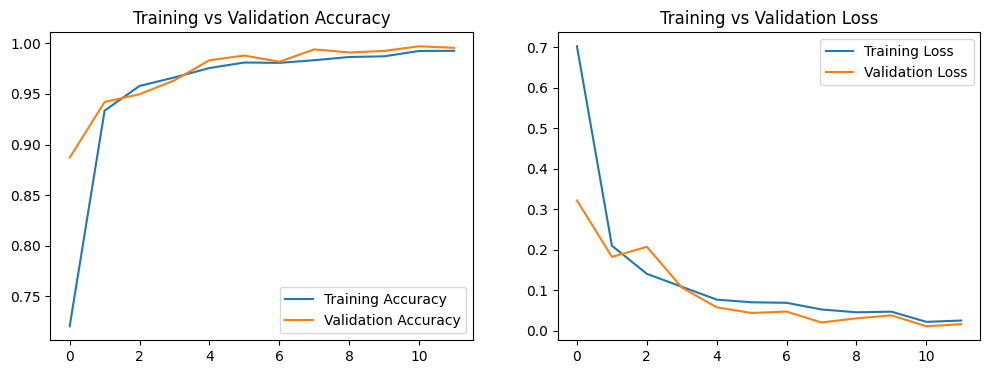

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(hist):
    plt.figure(figsize=(12, 4))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Training vs Validation Loss")

    plt.show()

# Call function after training
plot_training_curves(hist)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       150
           1       0.99      0.98      0.99       153
           2       1.00      1.00      1.00       203
           3       0.99      1.00      1.00       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



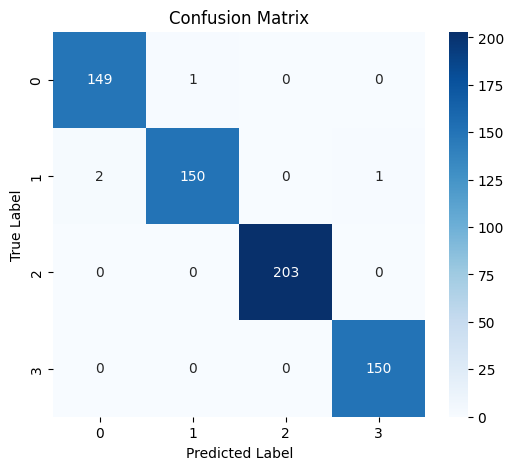

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predicted labels
y_true = test_gen.classes  # True labels from test set
y_pred_prob = model.predict(test_gen)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices

# Get class labels
class_labels = list(test_gen.class_indices.keys())

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [30]:
model.save("/kaggle/working/brain_tumor_xception_model.h5")